# Demonstration of StateSpacePTA.jl


This notebook demonstrates the use of `StateSpacePTA.jl` to generate some synthetic pulsar timing data and then use a UKF to recover the underlying state.


## 1. Single run example

In [106]:
using Revise
using Zygote
using DifferentialEquations

In [41]:
using DifferentialEquations
using Enzyme 



"""
The differential equation 
"""
function lorenz!(du,u,p,t)
    du[1] = p[1]*(u[2]-u[1])
    du[2] = u[1]*(p[2]-u[3]) - u[2]
    du[3] = u[1]*u[2] - p[3]*u[3]
    nothing
  end

"""
Given initial conditions a,b,c, integrate the system lorenz!()
"""
function timestepping(p)

    u0 = [1.0,1.0,1.0] #x,y,z starting coordinates 
    tspan = (0.0,100.0)

    σ = 10.0
    ρ = 28.0
    β = p

    params = [σ, ρ, β]
   
    prob = ODEProblem(lorenz!,u0,tspan,params)
    
    ode_solution = solve(prob,RK4())

    return ode_solution

end 

"""
An arbitrary loss function that returns the final value of the `a` variable at the end of the integration
"""
function loss_function(p)

    # #Do an integration 
    # a = 1.0
    # b = 2.0
    # c = c
    # #a,b,c = θ[1], θ[2],θ[3]
    solution = timestepping(p)

    #Get just the last element of the first variable as an arbitrary loss 
    critical_value = 28.546138914755634 - last(solution[3,:])
    
    return critical_value

end 






loss_function

In [42]:
#Just run once, make sure everything works OK
a# = 1.0
#b = 2.0
#c = 3.0
#θ = [a,b,c]
p = 8/3
first_attempt = loss_function(c)

#Now try to get a derivative
#second_attempt = Enzyme.autodiff(Forward,loss_function,Duplicated,Duplicated(a,1.0),Const(b),Const(c))

0.0

In [13]:
import Pkg; Pkg.add("SciMLSensitivity")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed GPUCompiler ────── v0.17.3
   Installed SciMLSensitivity ─ v7.25.0


┌ Warning: The active manifest file at `/Users/t1/github_repos/StateSpacePTA/Manifest.toml` has an old format that is being maintained.
│ To update to the new format run `Pkg.upgrade_manifest()` which will upgrade the format without re-resolving.
└ @ Pkg.Types /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.7/Pkg/src/manifest.jl:287
    Updating

 `~/github_repos/StateSpacePTA/Project.toml`
  [1ed8b502] + SciMLSensitivity v7.25.0
    Updating `~/github_repos/StateSpacePTA/Manifest.toml`
  [7057c7e9] + Cassette v0.3.11
  [082447d4] + ChainRules v1.48.0
  [da5c29d0] + EllipsisNotation v1.7.0
  [7da242da] + Enzyme v0.10.18
  [f151be2c] + EnzymeCore v0.1.0
  [d9f16b24] + Functors v0.3.0
  [0c68f7d7] + GPUArrays v8.6.3
  [61eb1bfa] + GPUCompiler v0.17.3
  [7869d1d1] + IRTools v0.4.8
  [929cbde3] + LLVM v4.16.0
  [872c559c] + NNlib v0.8.19
  [d8793406] + ObjectFile v0.3.7
  [3bd65402] + Optimisers v0.2.15
  [c1ae055f] + RealDot v0.1.0
  [37e2e3b7] + ReverseDiff v1.14.4
  [1ed8b502] + SciMLSensitivity v7.25.0
  [09ab397b] + StructArrays v0.6.14
  [53d494c1] + StructIO v0.3.0
 

 [a759f4b9] + TimerOutputs v0.5.22
  [9f7883ad] + Tracker v0.2.23
  [e88e6eb3] + Zygote v0.6.55


  [7cc45869] + Enzyme_jll v0.0.48+1


  [dad2f222] + LLVMExtra_jll v0.0.16+2
  [4af54fe1] + LazyArtifacts


┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /Users/t1/github_repos/StateSpacePTA/Manifest.toml:0


Precompiling project...


  ✓ GPUCompiler


  ✓ Enzyme


  ✓ SciMLSensitivity


  ✓ StateSpacePTA


  4 dependencies successfully precompiled in 110 seconds (329 already precompiled)
  2 dependencies precompiled but different versions are currently loaded. Restart julia to access the new versions


In [15]:
using Zygote
using SciMLSensitivity

In [44]:
v = [4,5,6]

#g_inverse_∂[1,1,:] = jacobian(x -> RelativisticDynamics.metric_contra_g11(x,a), [t r θ ϕ])[1]


cval = 8/3

Zygote.gradient(x -> loss_function(x),cval)[1]


4.809551783308395e35

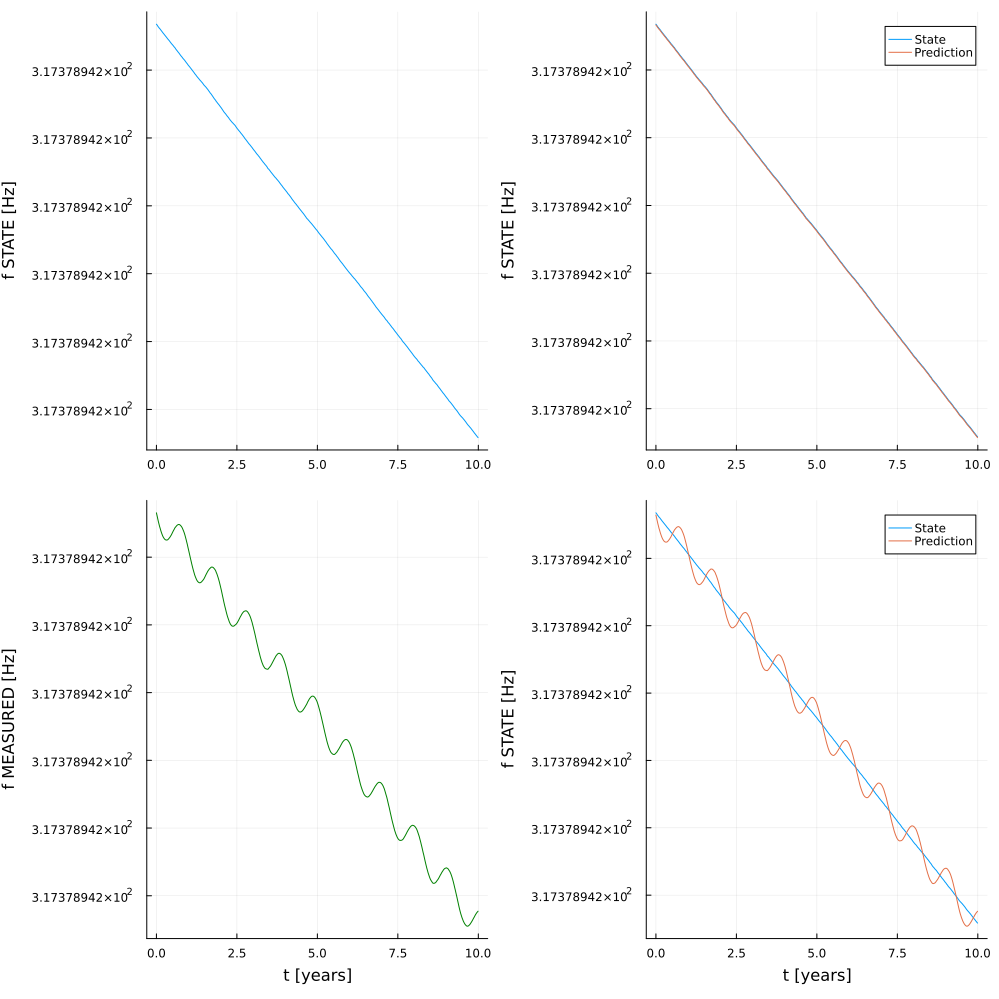

In [108]:
plotter(outputs["time"],outputs["state"],outputs["measurement"],outputs["model_predictions"],outputs["null_predictions"],15)

## 2. How does detectability vary with h?

In [127]:
using Plots 



function iterate(lower_limit, upper_limit,N,σp)

  
    h = 10 .^ range(lower_limit, stop=upper_limit, length=N)

    data = zeros((N,2))
    i = 1
    for hi in h 
    
        outputs = UKF(NF=Double64,h=hi,σp=σp);

        TS=outputs["TS"]

        data[i,1] = hi
        data[i,2] = TS
        i +=1

    end 


return data

end 


function plot_detection_vs_strain(d,tolerance,title)

    h = d[:,1]
    TS = d[:,2]

    positive_idx= (TS .> 0) #Indeces where the test statistic is positive. This is good. 
    negative_idx= (TS .< 0) #Indeces where the test statistic is positive. This is bad. 

   
    hplot, TSplot = h[positive_idx],TS[positive_idx]




    plt = plot(hplot, TSplot,xaxis=:log,yaxis=:log,xlabel="h", ylabel="TS",title=title,xticks = 10)
    scatter!(h[negative_idx],abs.(TS[negative_idx]))
    

    hline!([tolerance], color=:grey,linestyle=:dash,legend=false)

    
    filter_condition = (TSplot .> tolerance)

    x = hplot[filter_condition]
    y = TSplot[filter_condition]
    scatter!(x,y,color=:darkred)

    critical_value,idx = findmin(y)

    xc,yc = x[idx], y[idx]
   

    
    
    vline!([xc], color=:grey,linestyle=:dash,legend=false)
    println("Critical value: ", xc, " ", yc)

    display(plt)


end 





plot_detection_vs_strain (generic function with 2 methods)

In [129]:
h_low = -18
h_high = -8
N = 40

 
example_data_0 = iterate(h_low, h_high,N,0.0);
example_data_1 = iterate(h_low, h_high,N,1e-13);

In [131]:
using JLD 
save("../data/example_demo_data.jld", "example_data_0", example_data_0, "example_data_1", example_data_1)

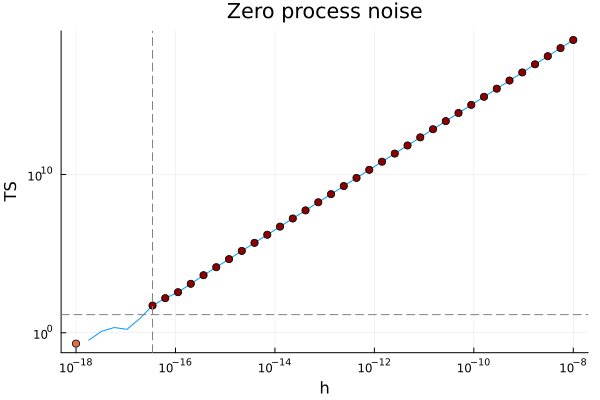

Critical value: 3.4551072945922325e-17 52.229458884413496
Critical value: 

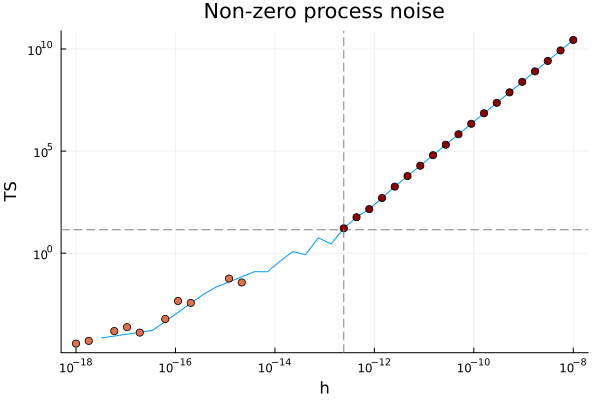

2.424462017082331e-13 16.554235281180574


In [132]:
plot_detection_vs_strain(example_data_0,14,"Zero process noise")
plot_detection_vs_strain(example_data_1,14, "Non-zero process noise")